# Problema 3 - Clasificación con distintas arquitecturas de red.

In [1]:
# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCHS = 20
num_clases = 6

In [2]:
from google.colab import drive


In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import zipfile
import os

# Ruta del archivo ZIP
zip_file_path = '/content/drive/MyDrive/AA2/TP1-3-natural-scenes.zip'
# Ruta donde se extraerán los archivos
extract_to = 'Dataset/'

# Crear la carpeta de extracción si no existe
os.makedirs(extract_to, exist_ok=True)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Archivos extraídos en: {extract_to}')


Archivos extraídos en: Dataset/


Importar librerías

In [5]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast, Dropout
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping

### Dataset

In [6]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("Dataset/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("Dataset/seg_test/seg_test")
PRED_DATA_DIRECTORY = Path("Dataset/seg_pred/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 120


# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [8]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [9]:
#train_ds = train_ds.take(200)
#val_ds = val_ds.take(100)

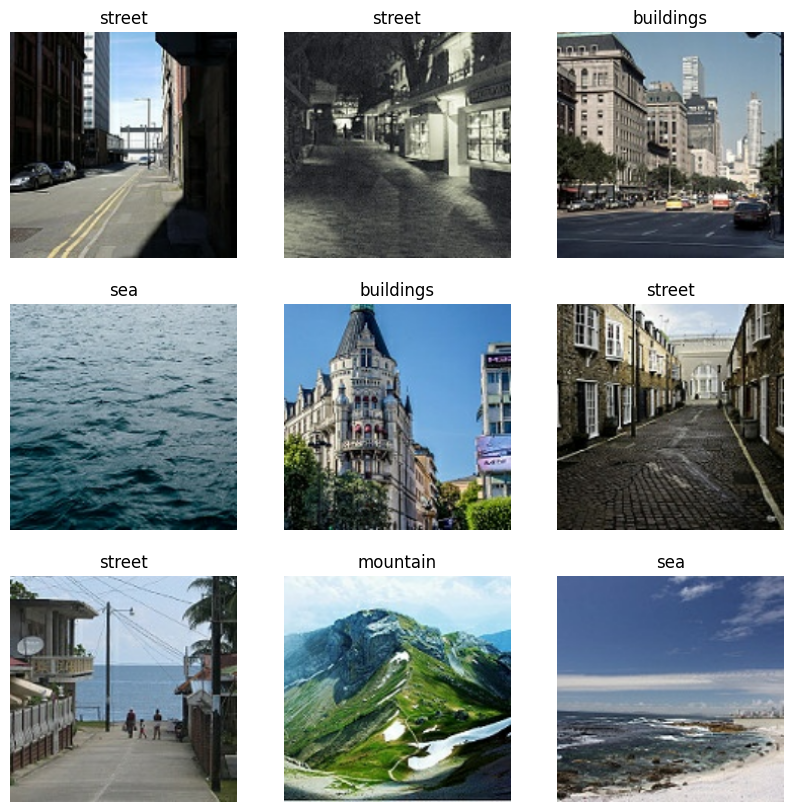

In [10]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

## Modelo con Capas Densas

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense

def dense_net(input_shape, num_classes):
    # Definir la entrada
    inputs = Input(shape=input_shape)

    # Aplicar Flatten a la entrada
    x = Flatten()(inputs)

    # Capas densas
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation = 'sigmoid')(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [12]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = 6
model_dense_net = dense_net(input_shape, num_classes)

model_dense_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │      37,632,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,506 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,759,256 (144.04 MB)

 Trainable params: 37,759,256 (144.04 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model_dense_net.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_dense_net = model_dense_net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.1746 - loss: 1.8311 - val_accuracy: 0.1807 - val_loss: 1.7941
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1615 - loss: 1.8096 - val_accuracy: 0.1943 - val_loss: 1.7894
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1722 - loss: 1.7953 - val_accuracy: 0.1580 - val_loss: 1.7986
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1735 - loss: 1.7961 - val_accuracy: 0.1750 - val_loss: 1.7940
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1686 - loss: 1.7959 - val_accuracy: 0.1843 - val_loss: 1.7896
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1723 - loss: 1.7965 - val_accuracy: 0.1750 - val_loss: 1.7966
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1723 - loss: 1.7973 - val_accuracy: 0.1843 - val_loss: 1.7904


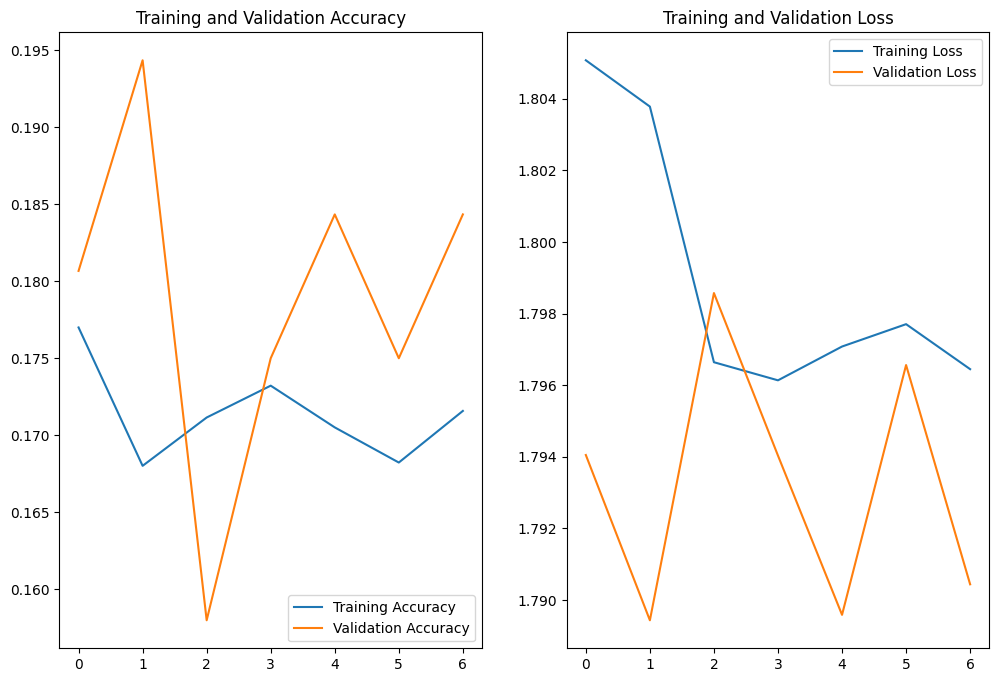

In [14]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dense_net.history['accuracy']
val_acc = history_dense_net.history['val_accuracy']

loss = history_dense_net.history['loss']
val_loss = history_dense_net.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


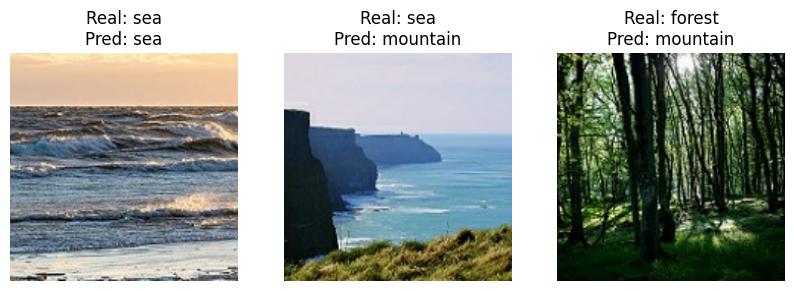

In [15]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_dense_net.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


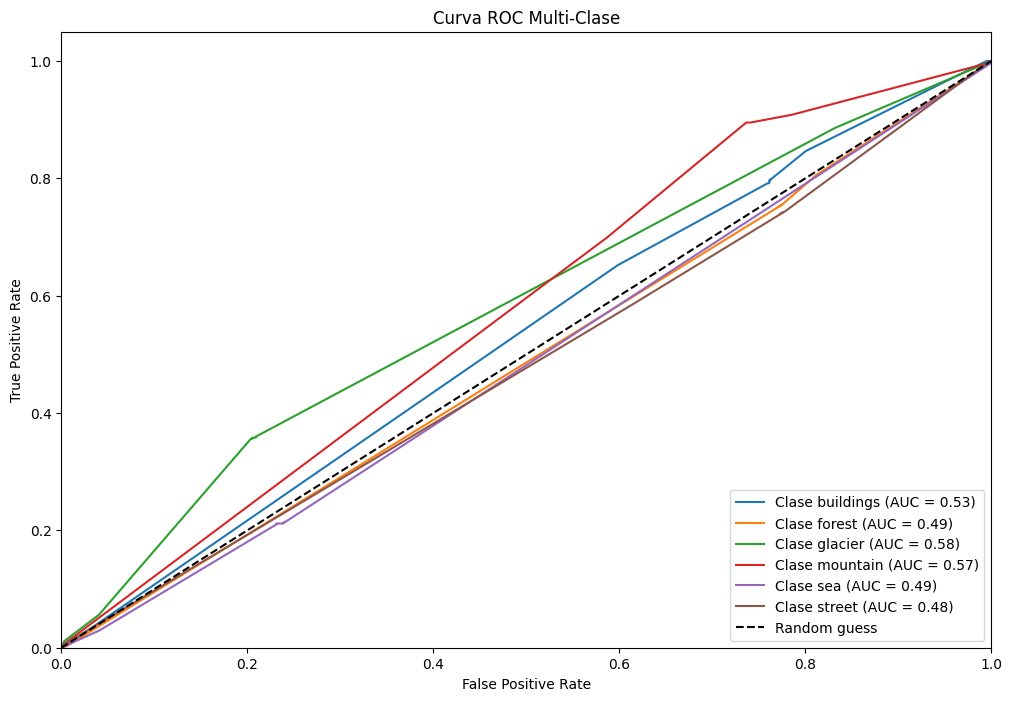

In [16]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_dense_net.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo con Capas Convolucionales y Densas

In [17]:
def conv_net(input_shape, num_classes):
    # Definir la entrada
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    # Capas convolucionales
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size = (2,2))(x)

    x = Conv2D(32 ,(3, 3), activation='relu', padding='same')(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x) #Aplanar
    x = Dropout(0.2)(x)
    # Capas densas
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation='relu')(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [18]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = 6
model_conv_net = conv_net(input_shape, num_classes)

model_conv_net.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model_conv_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 250)                 │       1,568,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │           1,506 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,538 (6.25 MB)

 Trainable params: 1,638,538 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Entrena el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_conv_net = model_conv_net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.2884 - loss: 38.2553 - val_accuracy: 0.6087 - val_loss: 1.0300
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6140 - loss: 1.0129 - val_accuracy: 0.6303 - val_loss: 0.9858
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6672 - loss: 0.8754 - val_accuracy: 0.6380 - val_loss: 0.9377
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7011 - loss: 0.7853 - val_accuracy: 0.6537 - val_loss: 0.9202
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7479 - loss: 0.6778 - val_accuracy: 0.6597 - val_loss: 0.9183
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7799 - loss: 0.5923 - val_accuracy: 0.6803 - val_loss: 0.9485
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8093 - loss: 0.5098 - val_accuracy: 0.6627 - val_loss: 0.9647
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8212 - loss: 0.4826 - val_a

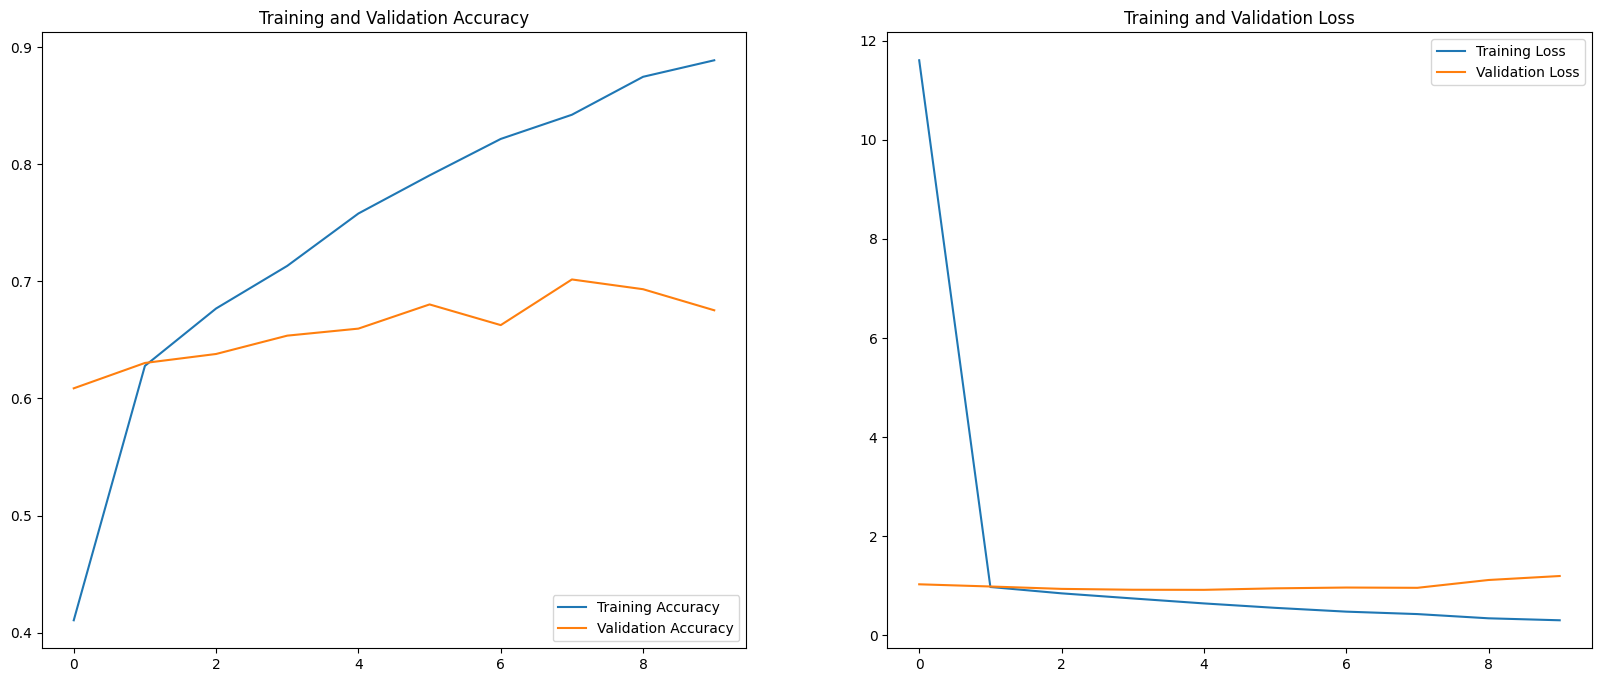

In [20]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv_net.history['accuracy']
val_acc = history_conv_net.history['val_accuracy']

loss = history_conv_net.history['loss']
val_loss = history_conv_net.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


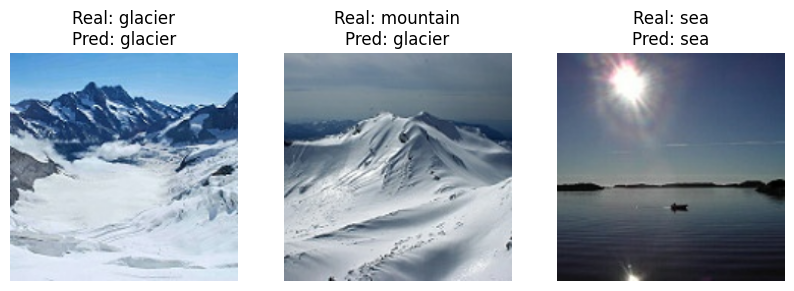

In [21]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_conv_net.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


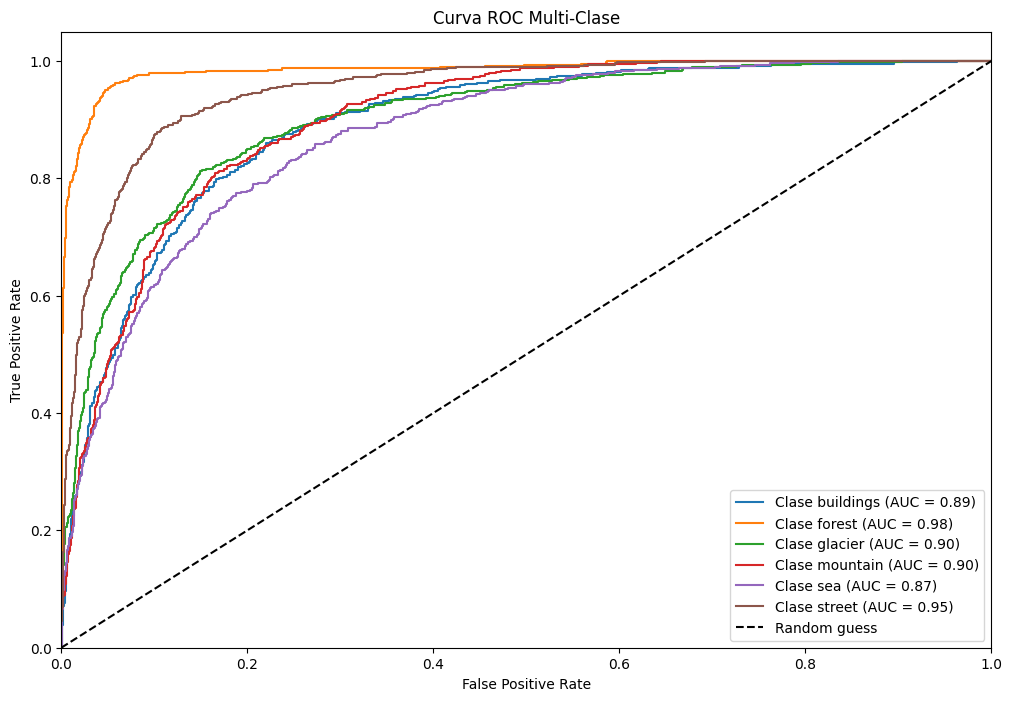

In [22]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_conv_net.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo que Incluya bloques residuales de identidad

In [23]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut (atajo)
    shortcut = x

    # Si el stride es mayor a 1 o los canales no coinciden, ajustamos el shortcut
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Primera convolución
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Segunda convolución
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Añadir el shortcut (proyectado o identidad)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)

    return x


In [24]:
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    # Capas convolucionales
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Bloques residuales
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Añadir más bloques residuales según la profundidad deseada
    x = residual_block(x, filters=128, stride=2)  # Reduce la dimensión
    x = residual_block(x, filters=128)

    # Capa de clasificación final
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dense(256, activation = 'relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
model_resnet = resnet(input_shape, 6)
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 224, 224, 32)   │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 74, 74, 32)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 74, 74, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 74, 74, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 74, 74, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 74, 74, 64)     │         36,928 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 74, 74, 64)     │          2,112 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 74, 74, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 74, 74, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 74, 74, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 74, 74, 64)     │         36,928 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 74, 74, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 74, 74, 64)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 827,206 (3.16 MB)

 Trainable params: 825,286 (3.15 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [26]:
# Entrena el modelo
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 99s 595ms/step - accuracy: 0.5613 - loss: 1.0840 - val_accuracy: 0.4590 - val_loss: 1.5480
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 388ms/step - accuracy: 0.7483 - loss: 0.6642 - val_accuracy: 0.6540 - val_loss: 0.8734
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 386ms/step - accuracy: 0.7742 - loss: 0.5883 - val_accuracy: 0.6843 - val_loss: 0.7956
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 387ms/step - accuracy: 0.8089 - loss: 0.5133 - val_accuracy: 0.6437 - val_loss: 0.9984
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 387ms/step - accuracy: 0.8289 - loss: 0.4622 - val_accuracy: 0.5103 - val_loss: 2.4431
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 387ms/step - accuracy: 0.8423 - loss: 0.4283 - val_accuracy: 0.7607 - val_loss: 0.7415
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 386ms/step - accuracy: 0.8567 - loss: 0.3957 - val_accuracy: 0.5750 - val_loss: 1.4569
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 387ms/step - accuracy: 0.8581 - loss: 0

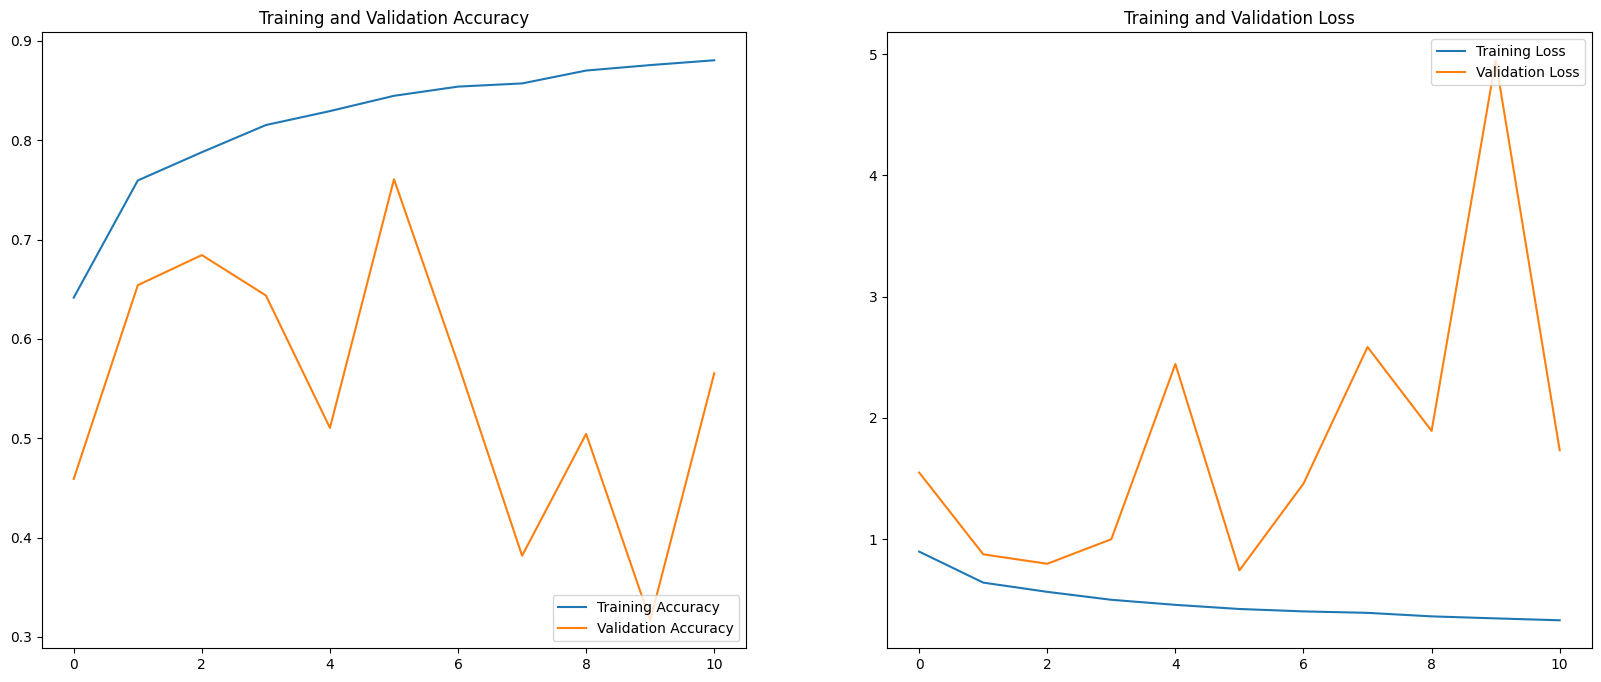

In [36]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


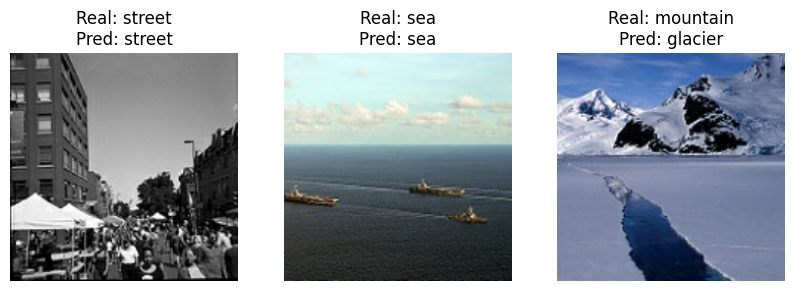

In [37]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_resnet.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


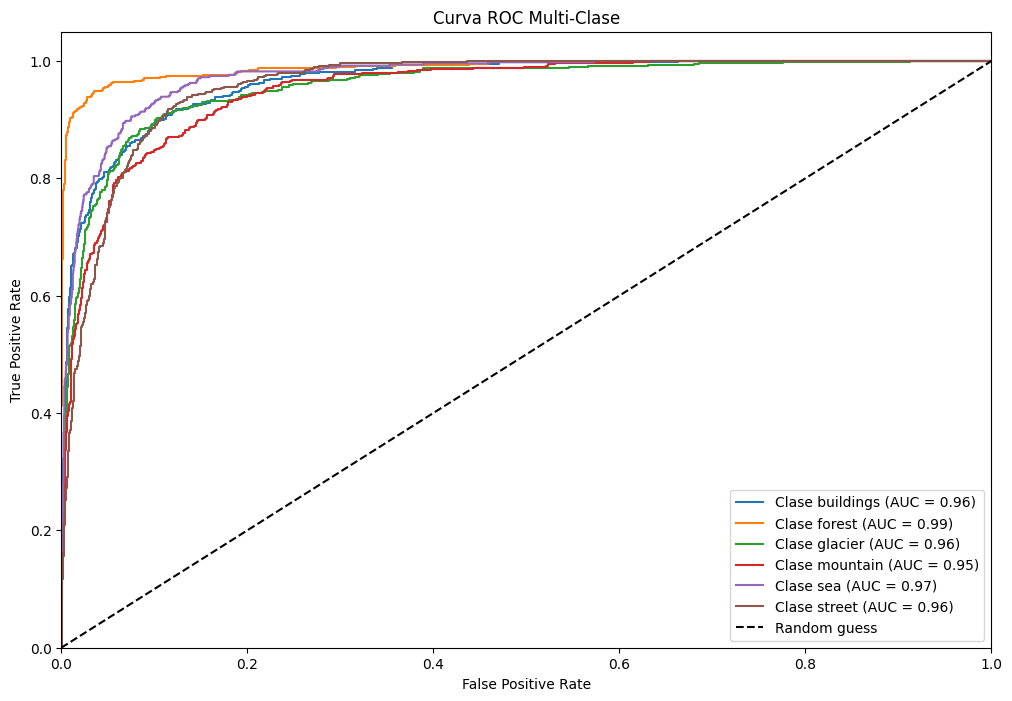

In [29]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_resnet.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo con BackBone

In [30]:
def backbone(input_shape, num_classes):
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)


In [31]:
model_backbone = backbone(input_shape, num_classes)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [32]:
# Compila el modelo con backbone
model_backbone.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_backbone = model_backbone.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)


Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 78s 506ms/step - accuracy: 0.6373 - loss: 2.5284 - val_accuracy: 0.8537 - val_loss: 0.7394
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.8640 - loss: 0.6612 - val_accuracy: 0.8580 - val_loss: 0.6633
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 366ms/step - accuracy: 0.8892 - loss: 0.4541 - val_accuracy: 0.8613 - val_loss: 0.6774
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 363ms/step - accuracy: 0.8980 - loss: 0.3838 - val_accuracy: 0.8470 - val_loss: 0.7943
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 365ms/step - accuracy: 0.9148 - loss: 0.3296 - val_accuracy: 0.8550 - val_loss: 0.6280
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9246 - loss: 0.2463 - val_accuracy: 0.8733 - val_loss: 0.5488
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 365ms/step - accuracy: 0.9331 - loss: 0.2144 - val_accuracy: 0.8610 - val_loss: 0.6159
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 365ms/step - accuracy: 0.9395 - loss: 0

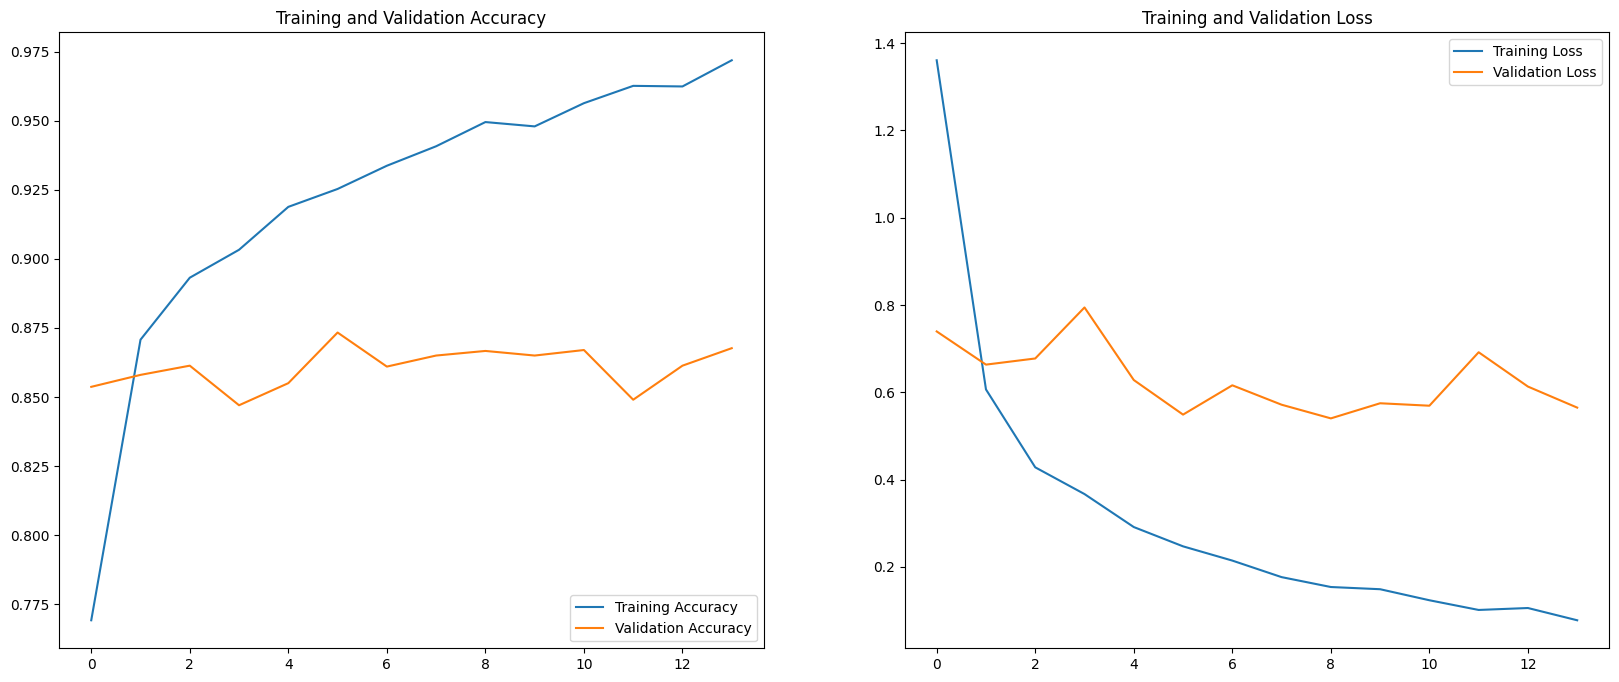

In [33]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_backbone.history['accuracy']
val_acc = history_backbone.history['val_accuracy']

loss = history_backbone.history['loss']
val_loss = history_backbone.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


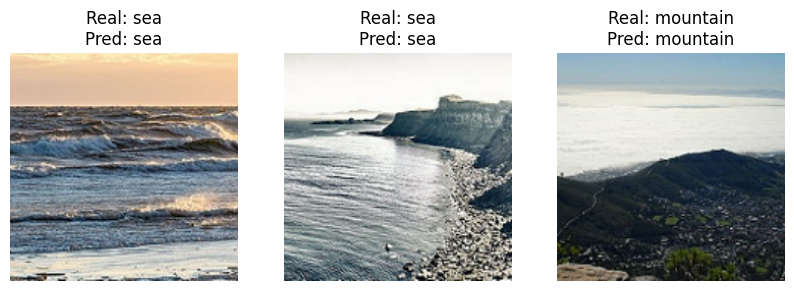

In [34]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_backbone.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


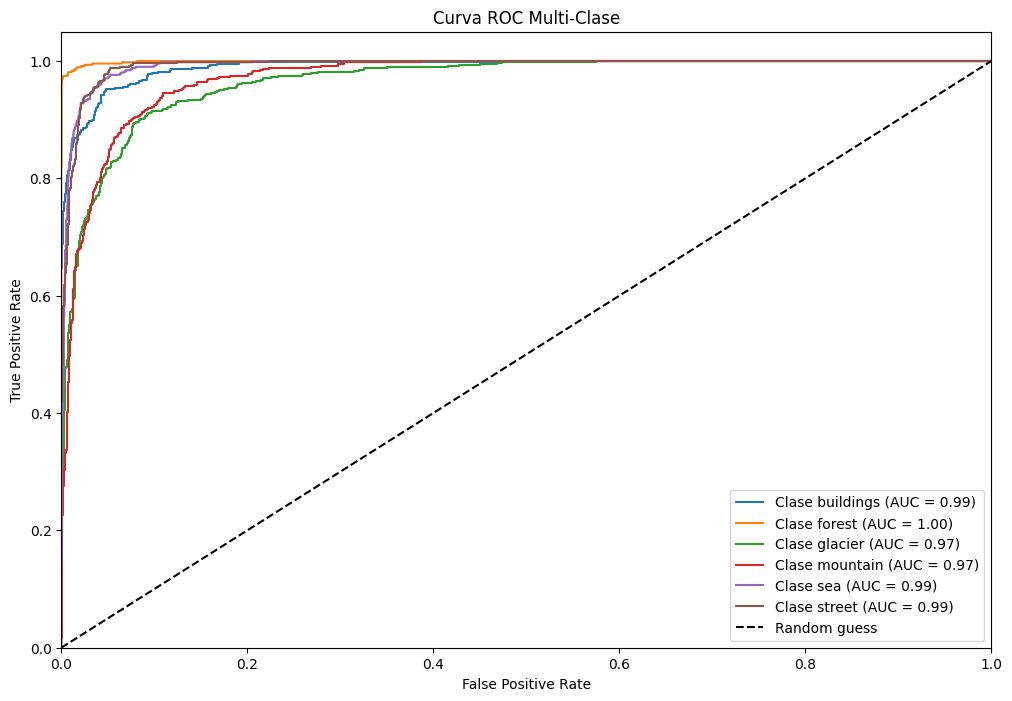

In [35]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_backbone.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()